### Introduction
Convolutional filtering is a basic signal processing technique used in electrical engineering, geophysics, image processing, machine learning, and many other fields.  This tutorial assumes no prior experience and explains basic concepts using a geophone response example. 
Concepts described in this tutorial include:
-  Impulse response
-  Linear and stationary
-  Convolution using superposition
-  A casual encounter with the z-transform
-  Convolution by polynomial multiplication
-  The standard computation method 



### The experiment
Consider a geophone that responds to a tap.  The output of the geophone is filtered and we plot the result.  Filters can be created with electronics and the results can be plotted on an oscilloscope.  You can also digitize the signal (convert the geophone voltage to computer data) and filter with a program.  This tutorial describes the computer program implementation of convolutional filtering.  This tutorial will discuss a filter that attempts to match a imaginary experiment.

### Import some libraries.

In [2]:
# this places the plots inline in the notebook
%matplotlib inline  
import numpy as np
import scipy as sp
import scipy.signal as sg
import matplotlib.pyplot as plt

### Define an impulse response
Let's define and impulse response for the filter.  Suppose with we tap the geophone we get a signal plotted below.  This is called the "impulse response".  This is not a useful filter, but is cooked up solely for this tutorial.  Filter design is a more advanced topic.

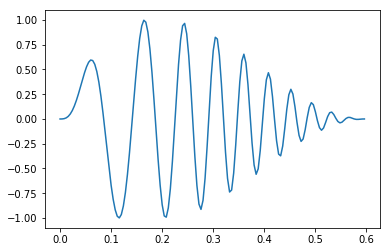

In [3]:
# define a linear frequency sweep with a 25 point cos squared ramp on 
# the ends.

filter=np.zeros(150)
deltat=.004
sweeplength=filter.size*deltat
fmax=30
fmin=4
sweep_rate=(fmax-fmin)/sweeplength
# define an upsweep or chirp
# freq(t)= fmin+ time * sweeprate
# dphase/dt= 2 * pi * freq(t) = 2*pi*(fmin+ time * sweeprate)
# integrate
# phase=2*pi*(fmin*time+1.0/2.0*time*time*sweeprate)
time=deltat*np.arange(filter.size,dtype=np.float32)
filter=np.sin(2*np.pi*(fmin*time+1.0/2.0*time*time*sweep_rate))
# ramp the ends
ramplength=25
ramp_radians=np.arange(ramplength,dtype=np.float32)/ramplength*np.pi/2.
# beginning ramp
filter[0:ramplength]=filter[0:ramplength]*np.square(np.sin(ramp_radians))
# end ramp
ramplength=100
ramp_radians=np.arange(ramplength,dtype=np.float32)/ramplength*np.pi/2.
filter[filter.size-ramplength:]=filter[filter.size-ramplength:]* \
                      np.square(np.cos(ramp_radians))
plt.plot(time,filter)
plt.show()

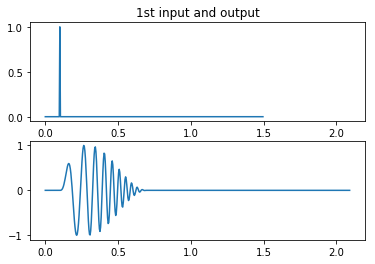

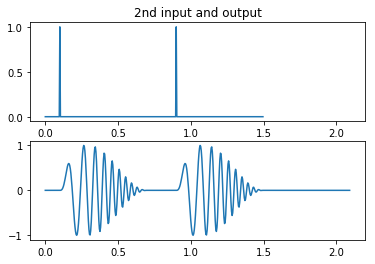

In [4]:
# make some plots, then describe them below plot
signal_in_length=375
signal_in=np.zeros(signal_in_length)
tapsample=25
signal_in[tapsample]=1.0
#signal_out=sg.lfilter(filter,             # filter (numerator)
#                      np.array([1.0]),                  # recursive filter (denominator)
#                      signal_in,axis=0)   
signal_out=np.convolve(signal_in,filter) #,mode='full')
view1=plt.subplot(211,title="1st input and output")
plt.plot(deltat*np.arange(signal_in.size,dtype=np.float32),signal_in)

view2=plt.subplot(212,sharex=view1)
plt.plot(deltat*np.arange(signal_out.size,dtype=np.float32),signal_out)
plt.show()

#signal_in=np.zeros(signal_in_length)
tapsample=225
signal_in[tapsample]=1.0
#signal_out=sg.lfilter(filter,             # filter (numerator)
#                      np.array([1.0]),                  # recursive filter (denominator)
#                      signal_in,axis=0)   
signal_out=np.convolve(signal_in,filter) #,mode='full')
view1=plt.subplot(211,title="2nd input and output")
plt.plot(deltat*np.arange(signal_in.size,dtype=np.float32),signal_in)

view2=plt.subplot(212,sharex=view1)
plt.plot(deltat*np.arange(signal_out.size,dtype=np.float32),signal_out)
plt.show()

### Stationary
These plots show a couple of taps on the geophone.  These show that it you tap once at .4 seconds you get a wavelet starting at .4 seconds.  It you tap twice (at .4 and 1.2 seconds) you get two wavelets (at .4 and 1.2 seconds).  You want the filter to produce the same result, regardless of when the geophone is tapped.  This is called __stationary__.

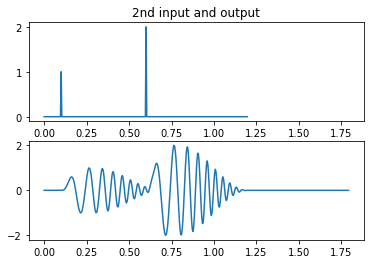

In [5]:
# make some plots, then describe them below plot
signal_in_length=300
signal_in=np.zeros(signal_in_length)
tapsample=25
signal_in[tapsample]=1.0

#signal_in=np.zeros(signal_in_length)
tapsample=150

signal_in[tapsample]=2
#signal_out=sg.lfilter(filter,             # filter (numerator)
#                      np.array([1.0]),                  # recursive filter (denominator)
#                      signal_in,axis=0)   
signal_out=np.convolve(signal_in,filter) #,mode='full')
view1=plt.subplot(211,title="2nd input and output")
plt.plot(deltat*np.arange(signal_in.size,dtype=np.float32),signal_in)

view2=plt.subplot(212,sharex=view1)
plt.plot(deltat*np.arange(signal_out.size,dtype=np.float32),signal_out)
plt.show()

### Linear
In this example, two spikes have different amplitude and are closer to each other than the filter length.  The output illustrates taping "twice as hard" produces a wavelet of "twice the amplitude".  When the wavelets are close together, the output sums the output wavelets where they overlap. These are the two properties of a linear operator.  You want your operators to be linear to simplify the math.  Linear algebra is the study of linear operators.

A geophone response is nearly linear.  Most physical transfer fundtions are not perfectly linear.  If you tap at the resonance frequency you may get growing displacement until it reaches a maximum amplitude and you start to get nonlinear response.  You might permanently damage the instrument.  In the normal operating range the instruments should be nearly linear.  The instrument manual may have distortion specifications that might be be a description of departure from linearity. 

### The superposition algorthm for convolution
To demonstrate an algorithm for convolution, we can use a short filter and a short input signal:
- filter (1, -.7, .1)
- signal_in (2, 4, -3, 1)

signal_out can be computed considering each of the signal_in points and computing how the filter will make the point contribute to signal_out.  By shifting the filter to line up with each of the signal_in points we get the table
```
              2   4   -3  1
signal_in contribution to
coef amp  signal_out 
1    2    2* (1,-.7, .1,  0,  0, 0)  (2,-1.4,  .2,0  , 0  , 0)
2    4    4* (0,  1,-.7, .1,  0, 0)  (0,   4,-2.8, .4, 0  , 0)
3    -3   -3*(0,  0,  1,-.7, .1, 0)  (0,   0,-3  ,2.1, -.3, 0)
4    1    1 *(0,  0,  0,  1,-.7,.1)  (0,   0, 0  ,1  , -.7,.1)
total                                (2, 2.6,-5.6,3.5,  -1,.1)
```
In this algorithm each signal_in amplitude is multipled by the filter and __scatterred__ to the output array.  The algorithm usually taught allows you to sit at each output location in signal_out, the output for convolution.  It is easier to __gather__ the contribution to each output location there are fewer intermediate results.  

In [95]:
# just check the arithmetic above
np.convolve(np.array([2., 4., -3., 1.]),np.array([1., -.7, .1]))

array([ 2. ,  2.6, -5.6,  3.5, -1. ,  0.1])

### A casual encounter with the z-transform
The Z-trasnform is usually an advanced topic.  I introduce it early to help me derive the traditional (gather) algorithm for convolution.  In geophysics the Z-transform of a sequence defined as:
\begin{equation*}X(z) = \mathcal{Z}\{x[n]\} =  \sum_{n=0}^{\infty} x[n] z^{n}.\end{equation*}
Most other disciplines, including electrical engineering use negative exponents on the z.  

The filter and signal_in sequences become polynomials in z:

filter (1, -.7, .1) transforms to: \begin{equation*} 1 -.7 z + .1 z^2 \end{equation*}
and signal_in (2, 4, -3, 1) transforms to: \begin{equation*} 2 +4 z -3  z^2 +z^3 \end{equation*}

If you multiple the polynomials you get:
\begin{equation*}(1 -.7z + .1z^2) (2 +4z -3z^2 +z^3) = 2 +2.6z -5.6  z^2 + 3.5z^3 - 1z^4 + .1z^5 \end{equation*}

This is exactly the z-transform of the convolution we cpreviously computed!  The order of our computations was the same as is we computed the polynomial multiplication by:

\begin{equation*} 2(1 -.7z + .1z^2) + 4z(1 -.7z + .1z^2) -3z^2(1 -.7z + .1z^2) +z^3(1 -.7z + .1z^2)\end{equation*}
This make a lot of sense when you learn that multiplication by z in the z-transform domain is the same as delay by a sample in the time domain.


### The standard computation method
Another way to do polynomial mulitplication is to group terms by the output power of z.  Reverse the filter and position it over the signal_in to identify the terms in z^0:
```
.1z^2 -  .7z  +   1
                  2 +  4z   -3z^2 +  1z^3
```
Multiply the lined up coefficients to get the output coefficient for z^0 is 2.  Then shift the filter to the right one coefficient:
```
       .1z^2 -  .7z  +   1
                  2  +  4z   -3z^2 +  1z^3
```
Multiply the lined up coefficients, sum and get the output coefficient for z^1 is -1.4+4 = 2.6.  Then shift the filter to the right again:
```
             .1z^2 -  .7z  +   1
                 2  +  4z   -3z^2 +  1z^3
```
Multiply the lined up coefficients, sum and get the output coefficient for z^2 is .2-2.8-3 = -5.6.  Then shift the filter to the right again:
```
                      .1z^2 -  .7z  +   1
                 2  +  4z   -3z^2 +  1z^3
```
Multiply the lined up coefficients, sum and get the output coefficient for z^3 is .4+2.1+1 = 3.5.  Then shift the filter to the right again:
```
                            .1z^2 -  .7z  +   1
                 2  +  4z   -3z^2 +  1z^3
```
Multiply the lined up coefficients, sum and get the output coefficient for z^4 is -.3-.7 = -1.  Then shift the filter to the right again:
```
                                    .1z^2 -  .7z  +   1
                 2  +  4z   -3z^2 +  1z^3
```
Multiply the lined up coefficients, sum and get the output coefficient for z^5 is .1.

This is algorithm usually described for convolution (but the z^n terms are not writen).





### Future reading
Linear Algebra
-  https://www.khanacademy.org/math/linear-algebra/vectors-and-spaces

Calculus
-  https://www.khanacademy.org/math/ap-calculus-ab I suggest you select "let us guide the way".  This leads to a warm up test , then recommends a study program.

Signal Processing (Convolution, correlation, autocorrelation) (requires good linear algebra,basic calculus, statistics)
-  https://www.edx.org/course/discrete-time-signals-systems-part-1-ricex-elec301-1x Started Feb 4
-  https://www.edx.org/course/discrete-time-signal-processing-mitx-6-341x-1 Maybe self-paced
-  https://www.edx.org/course/time-series-analysis-0 Starts May 14


